# Text Processing for Accelerator project

A simplified pipeline processing text with FastText.

* Load CPA classification data and removal of unwanted text
* Basic text cleaning
* Vectorize (with FastText)
* examine the vectorization using UMAP on one hand and PCA + TSNE on the other 
* Cluster (HDBSCAN)
* Evaluate
* Visualise

In [1]:
# this bit shouldn't be necessary if we pip install -e .   in the parent directory
%load_ext autoreload
%autoreload 2

In [2]:
import functools
from pprint import pprint
from time import time
from IPython.display import display, HTML
import logging
import pandas as pd
import numpy as np
import plotly.express

In [3]:
import text_processing

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load in the CPA data

In [108]:
CPA = text_processing.fetch_files()

2020-12-10 15:07:16,378 - text_processing - INFO - cleanded CPA File imported


In [109]:

CPA[CPA.Includes.notnull()].head()

Order  Level      Code   Parent  \
3   1208795      4     01.11     01.1   
19  1208811      6  01.11.50  01.11.5   
22  1208814      6  01.11.62  01.11.6   
24  1208816      5   01.11.7    01.11   
56  1208848      6  01.13.19  01.13.1   

                                                Descr_old  \
3   Cereals (except rice), leguminous crops and oil seeds   
19                                Cereals straw and husks   
22                                            Peas, green   
24                            Dried leguminous vegetables   
56                         Other leafy or stem vegetables   

                                       Descr  \
3   Cereals , leguminous crops and oil seeds   
19                   Cereals straw and husks   
22                               Peas, green   
24               Dried leguminous vegetables   
56            Other leafy or stem vegetables   

                                                                               Includes  \
3             cereals, leguminous crops and oil seeds grown for food and other purposes   
19  unprepared straw, whether or not chopped, ground, pressed or in the form of pellets   
22                                                           green peas and forage peas   
24                        leguminous vegetables, dried, whether or not shelled or split   
56                                                                              parsley   

   Category_2 Category_3 Category_1 Category_0  
3          01       01.1          A          1  
19         01       01.1          A          1  
22         01       01.1          A          1  
24         01       01.1          A          1  
56         01       01.1          A          1

In [110]:
CPA1 = CPA[['Code','Level','Descr_old','Descr','Includes','Category_0','Category_1','Category_2']].copy()
CPA2 = CPA[['Code','Level','Descr_old','Includes','Descr','Category_0','Category_1','Category_2']].copy()
CPA2['Full_descr'] = CPA2.Descr_old.fillna('') + CPA2.Includes.fillna('')
CPA2 = CPA2.drop('Descr',axis=1)
CPA2 = CPA2.rename(columns={'Full_descr':'Descr'})
df1 = text_processing.clean_col(CPA1, "Descr")
df2 = text_processing.clean_col(CPA2, "Descr")

2020-12-10 15:07:17,063 - text_processing - INFO - Cleaning column: Descr 
2020-12-10 15:07:17,108 - text_processing - INFO - Cleaning column: Descr 


In [111]:
def show_group(df, search_col, start_str):
    l = len(start_str)
    df1 = df[df[search_col].str[:l] == start_str]
    display(df1)
show_group(df1, 'Code', '01.11')
show_group(df2, 'Code', '01.11')

Code  Level                                              Descr_old  \
3      01.11      4  Cereals (except rice), leguminous crops and oil seeds   
4    01.11.1      5                                                  Wheat   
5   01.11.11      6                                            Durum wheat   
6   01.11.12      6                              Wheat, except durum wheat   
7    01.11.2      5                                                  Maize   
8   01.11.20      6                                                  Maize   
9    01.11.3      5                                   Barley, rye and oats   
10  01.11.31      6                                                 Barley   
11  01.11.32      6                                                    Rye   
12  01.11.33      6                                                   Oats   
13   01.11.4      5                      Sorghum, millet and other cereals   
14  01.11.41      6                                                Sorghum   
15  01.11.42      6                                                 Millet   
16  01.11.43      6                                              Triticale   
17  01.11.49      6                                          Other cereals   
18   01.11.5      5                                Cereals straw and husks   
19  01.11.50      6                                Cereals straw and husks   
20   01.11.6      5                            Green leguminous vegetables   
21  01.11.61      6                                           Beans, green   
22  01.11.62      6                                            Peas, green   
23  01.11.69      6                      Other green leguminous vegetables   
24   01.11.7      5                            Dried leguminous vegetables   
25  01.11.71      6                                             Beans, dry   
26  01.11.72      6                                       Broad beans, dry   
27  01.11.73      6                                        Chick peas, dry   
28  01.11.74      6                                           Lentils, dry   
29  01.11.75      6                                              Peas, dry   
30  01.11.76      6                                               Cow peas   
31  01.11.77      6                                       Pigeon peas, dry   
32  01.11.79      6            Pulses (dried leguminous vegetables) n.e.c.   
33   01.11.8      5                              Soya beans and groundnuts   
34  01.11.81      6                                             Soya beans   
35  01.11.82      6                                   Groundnuts, in shell   
36   01.11.9      5                                        Other oil seeds   
37  01.11.91      6                                               Lin seed   
38  01.11.92      6                                           Mustard seed   
39  01.11.93      6                                     Rape or colza seed   
40  01.11.94      6                                            Sesame seed   
41  01.11.95      6                                         Sunflower seed   
42  01.11.96      6                                       Castor oil seeds   
43  01.11.99      6                                 Other oil seeds n.e.c.   

                                       Descr  \
3   Cereals , leguminous crops and oil seeds   
4                                      Wheat   
5                                Durum wheat   
6                                      Wheat   
7                                      Maize   
8                                      Maize   
9                       Barley, rye and oats   
10                                    Barley   
11                                       Rye   
12                                      Oats   
13         Sorghum, millet and other cereals   
14                                   Sorghum   
15                                    Millet   
16                                 Triticale   
17         

Code  Level                                              Descr_old  \
3      01.11      4  Cereals (except rice), leguminous crops and oil seeds   
4    01.11.1      5                                                  Wheat   
5   01.11.11      6                                            Durum wheat   
6   01.11.12      6                              Wheat, except durum wheat   
7    01.11.2      5                                                  Maize   
8   01.11.20      6                                                  Maize   
9    01.11.3      5                                   Barley, rye and oats   
10  01.11.31      6                                                 Barley   
11  01.11.32      6                                                    Rye   
12  01.11.33      6                                                   Oats   
13   01.11.4      5                      Sorghum, millet and other cereals   
14  01.11.41      6                                                Sorghum   
15  01.11.42      6                                                 Millet   
16  01.11.43      6                                              Triticale   
17  01.11.49      6                                          Other cereals   
18   01.11.5      5                                Cereals straw and husks   
19  01.11.50      6                                Cereals straw and husks   
20   01.11.6      5                            Green leguminous vegetables   
21  01.11.61      6                                           Beans, green   
22  01.11.62      6                                            Peas, green   
23  01.11.69      6                      Other green leguminous vegetables   
24   01.11.7      5                            Dried leguminous vegetables   
25  01.11.71      6                                             Beans, dry   
26  01.11.72      6                                       Broad beans, dry   
27  01.11.73      6                                        Chick peas, dry   
28  01.11.74      6                                           Lentils, dry   
29  01.11.75      6                                              Peas, dry   
30  01.11.76      6                                               Cow peas   
31  01.11.77      6                                       Pigeon peas, dry   
32  01.11.79      6            Pulses (dried leguminous vegetables) n.e.c.   
33   01.11.8      5                              Soya beans and groundnuts   
34  01.11.81      6                                             Soya beans   
35  01.11.82      6                                   Groundnuts, in shell   
36   01.11.9      5                                        Other oil seeds   
37  01.11.91      6                                               Lin seed   
38  01.11.92      6                                           Mustard seed   
39  01.11.93      6                                     Rape or colza seed   
40  01.11.94      6                                            Sesame seed   
41  01.11.95      6                                         Sunflower seed   
42  01.11.96      6                                       Castor oil seeds   
43  01.11.99      6                                 Other oil seeds n.e.c.   

                                                                               Includes  \
3             cereals, leguminous crops and oil seeds grown for food and other purposes   
4                                                                                   NaN   
5                                                                                   NaN   
6                                                                                   NaN   
7                                                                                   NaN   
8                                                                                   NaN   
9                                                                                   NaN   
10 

## Load FastText Pretrained

Note: This requires a fair bit of memory (peaks at about 17.5 GiB)

Recommend shutting down other kernels first, once this has loaded memory usage drops again.

This takes a few minutes to load in.

In [112]:
wv = text_processing.fetch_fasstext_pretrained(filepath="../../data/wiki.en.bin")

2020-12-10 15:07:18,527 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin


MemoryError: Unable to allocate 2.82 GiB for an array with shape (2519370, 300) and data type float32

## Vectorize descriptions using FastText

In [107]:
text_to_vec = functools.partial(text_processing.vectorize_text, wv)

df1["Descr_cleaned_vectorized"] = df1.Descr_cleaned.apply(
    text_to_vec
)
df2["Descr_cleaned_vectorized"] = df2.Descr_cleaned.apply(
    text_to_vec
)

## Dimensionality Reduction - UMAP with 10 dimensions 

In [83]:
df2.head(1)

Code  Level                                      Descr_old Includes  \
0    A      1  PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING      NaN   

                                           Descr Category_0 Category_1  \
0  PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING          1          A   

  Category_2                          Descr_cleaned  \
0        NaN  products agriculture forestry fishing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Descr_cleaned_vectorized  
0  [0.05488733, 0.10263896, -0.09368554, 0.19250718, -0.22911839, 0.1134942, 0.19989246, -0.34521505, 0.20580906, 0.22284631, -0.007808514, 0.30888015, 0.060562663, -0.10893961, 0.051866308, -0.20197225, 0.094760954, 0.14932719, 0.15708452, 0.2185415, 0.023390101, 0.089312606, 0.022895709, -0.22182912, -0.05598179, 0.054932404, -0.093378454, -0.2176079, 0.049127385, 0.010258881, 0.14984986, 0.38789344, -0.34044507, 0.29452312, 0.04464947, -0.12954769, -0.078150794, 0.0028720193, -0.039931707, -0.0019557115, 0.007408805, 0.021678519, 0.0099723125, -0.16618188, 0.06853781, 0.14642733, 0.17984611, -0.25487494, 0.08622599, 0.0765772, 0.13162443, 0.03302535, -0.202643, 0.11979215, -0.3522296, 0.003318471, -0.05803647, 0.0984039, -0.08421728, 0.15938002, -0.37299323, -0.13701719, 0.073302574, -0.3492735, 0.042315863, -0.224927, -0.25032312, -0.3374133, -0.20211494, -0.061002742, -0.061206426, 0.11996332, 0.47937027, -0.15443501, -0.22621408, -0.2241789, 0.31829298, 0.17782009, -0.113770455, 0.12229881, 0.15257512, 0.14008573, 0.20958829, -0.052617524, -0.11466411, -0.3148144, 0.06309645, 0.20886008, 0.199444, -0.008423858, 0.22599153, 0.06367118, 0.16501212, -0.37722147, 0.007624693, 0.30878863, 0.04852303, 0.3831182, 0.024110619, -0.23171967, ...]

In [98]:
df1["Low_dim"] = text_processing.reduce_dimensionality(
    df1.Descr_cleaned_vectorized, 10
)
df2["Low_dim"] = text_processing.reduce_dimensionality(
    df2.Descr_cleaned_vectorized, 10
)

2020-12-10 14:57:20,304 - text_processing - INFO - Now applying umap to reduce dimension


UMAP(min_dist=0.0, n_components=10, n_neighbors=10, random_state=3052528580,
     verbose=10)
Construct fuzzy simplicial set
Thu Dec 10 14:57:20 2020 Finding Nearest Neighbors
Thu Dec 10 14:57:20 2020 Building RP forest with 9 trees
Thu Dec 10 14:57:20 2020 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	 9  /  12
	 10  /  12
Thu Dec 10 14:57:21 2020 Finished Nearest Neighbor Search
Thu Dec 10 14:57:21 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


2020-12-10 14:57:39,115 - text_processing - INFO - Now applying umap to reduce dimension


Thu Dec 10 14:57:39 2020 Finished embedding
UMAP(min_dist=0.0, n_components=10, n_neighbors=10, random_state=3052528580,
     verbose=10)
Construct fuzzy simplicial set
Thu Dec 10 14:57:39 2020 Finding Nearest Neighbors
Thu Dec 10 14:57:39 2020 Building RP forest with 9 trees
Thu Dec 10 14:57:39 2020 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	 9  /  12
	 10  /  12
Thu Dec 10 14:57:39 2020 Finished Nearest Neighbor Search
Thu Dec 10 14:57:40 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Dec 10 14:57:57 2020 Finished embedding


### Clustering

In [106]:
df1 = df1[df1.Level==6].copy()
df2 = df2[df2.Level==6].copy()
df1["label"] = text_processing.cluster(df1.Low_dim)
df2["label"] = text_processing.cluster(df2.Low_dim)
# df1 = df1.drop(['Descr_cleaned_vectorized'], axis=1)
# df2 = df2.drop(['Descr_cleaned_vectorized'], axis=1)
show_group(df1[df1.Includes.notnull()], 'Code', '01.11')
show_group(df2[df2.Includes.notnull()], 'Code', '01.11')

Code  Level                Descr_old                    Descr  \
19  01.11.50      6  Cereals straw and husks  Cereals straw and husks   
22  01.11.62      6              Peas, green              Peas, green   

                                                                               Includes  \
19  unprepared straw, whether or not chopped, ground, pressed or in the form of pellets   
22                                                           green peas and forage peas   

   Category_0 Category_1 Category_2        Descr_cleaned  \
19          1          A         01  cereals straw husks   
22          1          A         01           peas green   

                                                                                                                                                                                               Low_dim  \
19    [10.37432861328125, 1.7721384763717651, 5.094308376312256, 7.391745090484619, 2.050753355026245, 6.653661251068115, 3.7789061069488525, 5.246798992156982, 9.736446380615234, 3.434803009033203]   
22  [10.237520217895508, 1.910762906074524, 5.074232578277588, 7.2127532958984375, 2.107407569885254, 6.951172828674316, 3.907716751098633, 5.1662797927856445, 10.246707916259766, 3.279151201248169]   

   label  
19   171  
22   185

Code  Level                Descr_old  \
19  01.11.50      6  Cereals straw and husks   
22  01.11.62      6              Peas, green   

                                                                               Includes  \
19  unprepared straw, whether or not chopped, ground, pressed or in the form of pellets   
22                                                           green peas and forage peas   

   Category_0 Category_1 Category_2  \
19          1          A         01   
22          1          A         01   

                                                                                                         Descr  \
19  Cereals straw and husksunprepared straw, whether or not chopped, ground, pressed or in the form of pellets   
22                                                                       Peas, greengreen peas and forage peas   

                                                                      Descr_cleaned  \
19  cereals straw husksunprepared straw whether chopped ground pressed form pellets   
22                                                 peas greengreen peas forage peas   

                                                                                                                                                                                               Low_dim  \
19    [10.37432861328125, 1.7721384763717651, 5.094308376312256, 7.391745090484619, 2.050753355026245, 6.653661251068115, 3.7789061069488525, 5.246798992156982, 9.736446380615234, 3.434803009033203]   
22  [10.237520217895508, 1.910762906074524, 5.074232578277588, 7.2127532958984375, 2.107407569885254, 6.951172828674316, 3.907716751098633, 5.1662797927856445, 10.246707916259766, 3.279151201248169]   

   label  
19   171  
22   185

2020-12-10 14:57:58,385 - text_processing - INFO - cleanded CPA File imported
/home/jupyter/Data-science-accelerator/src/text_processing.py:142: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



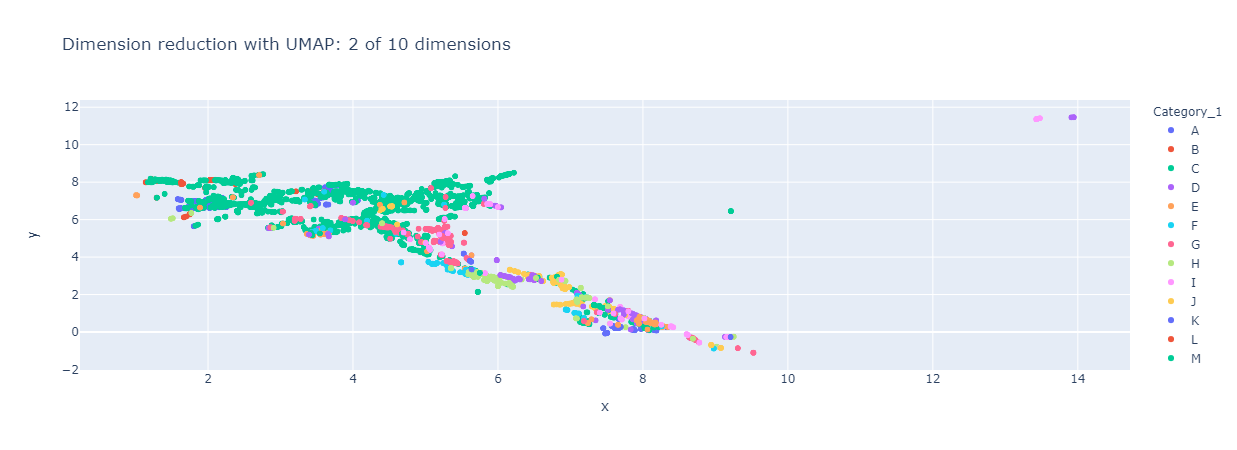

In [100]:
plot_df = df2[["Category_1","Descr_cleaned", "Code", "Low_dim","label"]].copy()
plot_df['Category'] = plot_df['Category_1'].astype(str)
i=2
plot_df["x"] = plot_df.Low_dim.apply(lambda x: x[2*i])
plot_df["y"] = plot_df.Low_dim.apply(lambda x: x[2*i+1])

fig1 = text_processing.plotly_scat(plot_df,'1',['Descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')
fig1.update_layout()


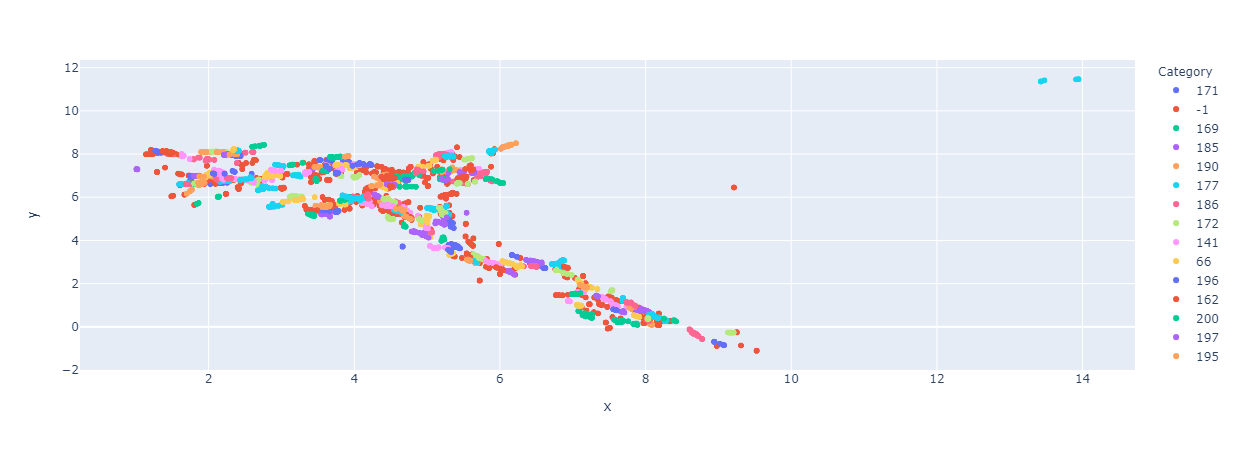

In [28]:

# add filtering
# a function to produce a scatter plot
def scat(plot_df, true_cols):
    hover = {
        "Category":False,
        "x": False,
        "y": False
        }
    for col in true_cols:
        hover[col] = True
    fig = plotly.express.scatter(
            plot_df, 
            x="x", 
            y="y", 
            color="Category",
            hover_data=hover)
    return fig
#fig1 = text_processing.plotly_scat(plot_df,'label',['Full_descr_cleaned','label'], 'Dimension reduction with UMAP: 2 of 10 dimensions')

plot_df = df1[["Category_1","Descr_cleaned", "Code", "Low_dim","label"]].copy()
plot_df['Category'] = plot_df.label.astype(str)

plot_df["x"] = plot_df.Low_dim.apply(lambda x: x[4])
plot_df["y"] = plot_df.Low_dim.apply(lambda x: x[5])

fig1 = scat(plot_df,['Descr_cleaned','label'])
fig1.update_layout()

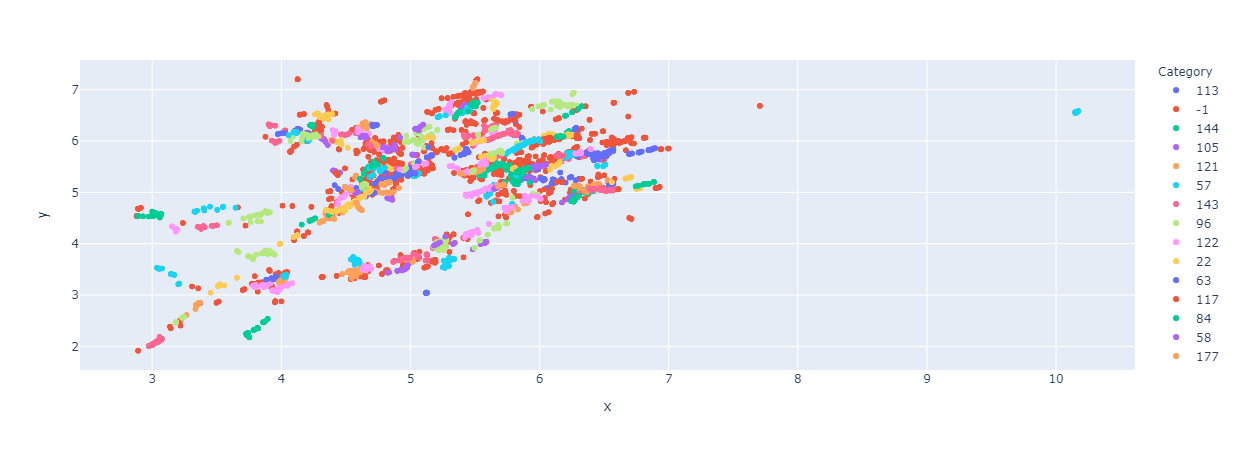

In [29]:
plot_df = df2[["Category_1","Full_descr_cleaned", "Code", "Low_dim","label"]].copy()
plot_df['Category'] = plot_df.label.astype(str)

plot_df["x"] = plot_df.Low_dim.apply(lambda x: x[4])
plot_df["y"] = plot_df.Low_dim.apply(lambda x: x[5])

fig1 = scat(plot_df,['Full_descr_cleaned','label'])
fig1.update_layout()

In [ ]:
plot_df[plot_df.label==3]

## Investigate the new categories

In [101]:
df1.head()

Code  Level                  Descr_old        Descr Includes  \
5   01.11.11      6                Durum wheat  Durum wheat      NaN   
6   01.11.12      6  Wheat, except durum wheat        Wheat      NaN   
8   01.11.20      6                      Maize        Maize      NaN   
10  01.11.31      6                     Barley       Barley      NaN   
11  01.11.32      6                        Rye          Rye      NaN   

   Category_0 Category_1 Category_2 Descr_cleaned  \
5           1          A         01   durum wheat   
6           1          A         01         wheat   
8           1          A         01         maize   
10          1          A         01        barley   
11          1          A         01           rye   

                                                                                                                                                                                                 Low_dim  \
5   [10.291918754577637, 1.7045024633407593, 5.092067241668701, 7.395353317260742, 2.1467156410217285, 6.6684675216674805, 3.7731988430023193, 5.214673042297363, 9.758365631103516, 3.4810309410095215]   
6     [10.287755966186523, 1.6951987743377686, 5.097175598144531, 7.395287990570068, 2.1621150970458984, 6.66406774520874, 3.7755863666534424, 5.209231376647949, 9.753708839416504, 3.4842824935913086]   
8      [10.313942909240723, 1.829215168952942, 4.938665866851807, 7.366335391998291, 1.9432837963104248, 6.621471881866455, 3.8021445274353027, 5.304760456085205, 9.595613479614258, 3.541586399078369]   
10    [10.303442001342773, 1.7070399522781372, 5.099334716796875, 7.389023780822754, 2.151716947555542, 6.656326770782471, 3.7882468700408936, 5.208776473999023, 9.748895645141602, 3.4680426120758057]   
11       [10.27916431427002, 1.6720035076141357, 5.144863128662109, 7.367682456970215, 2.254650831222534, 6.67072868347168, 3.82017183303833, 5.1649394035339355, 9.804200172424316, 3.4379947185516357]   

   label  
5    171  
6    171  
8     -1  
10   171  
11   171

In [102]:
df2.head()

Code  Level                  Descr_old Includes Category_0 Category_1  \
5   01.11.11      6                Durum wheat      NaN          1          A   
6   01.11.12      6  Wheat, except durum wheat      NaN          1          A   
8   01.11.20      6                      Maize      NaN          1          A   
10  01.11.31      6                     Barley      NaN          1          A   
11  01.11.32      6                        Rye      NaN          1          A   

   Category_2                      Descr             Descr_cleaned  \
5          01                Durum wheat               durum wheat   
6          01  Wheat, except durum wheat  wheat except durum wheat   
8          01                      Maize                     maize   
10         01                     Barley                    barley   
11         01                        Rye                       rye   

                                                                                                                                                                                                 Low_dim  \
5   [10.291918754577637, 1.7045024633407593, 5.092067241668701, 7.395353317260742, 2.1467156410217285, 6.6684675216674805, 3.7731988430023193, 5.214673042297363, 9.758365631103516, 3.4810309410095215]   
6     [10.287755966186523, 1.6951987743377686, 5.097175598144531, 7.395287990570068, 2.1621150970458984, 6.66406774520874, 3.7755863666534424, 5.209231376647949, 9.753708839416504, 3.4842824935913086]   
8      [10.313942909240723, 1.829215168952942, 4.938665866851807, 7.366335391998291, 1.9432837963104248, 6.621471881866455, 3.8021445274353027, 5.304760456085205, 9.595613479614258, 3.541586399078369]   
10    [10.303442001342773, 1.7070399522781372, 5.099334716796875, 7.389023780822754, 2.151716947555542, 6.656326770782471, 3.7882468700408936, 5.208776473999023, 9.748895645141602, 3.4680426120758057]   
11       [10.27916431427002, 1.6720035076141357, 5.144863128662109, 7.367682456970215, 2.254650831222534, 6.67072868347168, 3.82017183303833, 5.1649394035339355, 9.804200172424316, 3.4379947185516357]   

   label  
5    171  
6    171  
8     -1  
10   171  
11   171

In [38]:
def search_col(df, search_col, display_cols, st):
    st1 = st.lower()
    df1 = df[df[search_col].fillna('').str.contains(st1)]
    # display(df1[display_cols])
    return df1[display_cols]

dis_cols = ['Code','Descr_old','Descr_cleaned','label']
dis_cols2 = ['Code','Descr_old','Full_descr_cleaned','label']

test1 = search_col(df1, 'Descr_cleaned', dis_cols,'caravan')
test2 = search_col(df2, 'Full_descr_cleaned', dis_cols2,'caravan')
display(test1,test2)

Code                                          Descr_old  \
2929  29.20.22  Trailers and semi-trailers of the caravan type...   
2936  29.20.50  Fitting out services of caravans and mobile homes   
3639  45.19.12  Wholesale trade services of camping vehicles s...   
3642  45.19.22  Specialised store retail trade services of cam...   
4978  77.39.13  Rental and leasing services of motorcycles, ca...   

                                          Descr_cleaned label  
2929  trailers semi-trailers caravan type housing ca...    31  
2936             fitting services caravans mobile homes    31  
3639  wholesale trade services camping vehicles cara...    31  
3642  specialised store retail trade services campin...    31  
4978  rental leasing services motorcycles caravans c...    28

Code                                          Descr_old  \
2929  29.20.22  Trailers and semi-trailers of the caravan type...   
2936  29.20.50  Fitting out services of caravans and mobile homes   
3639  45.19.12  Wholesale trade services of camping vehicles s...   
3642  45.19.22  Specialised store retail trade services of cam...   
4670  68.20.12  Rental and operating services of own or leased...   
4978  77.39.13  Rental and leasing services of motorcycles, ca...   

                                     Full_descr_cleaned label  
2929  trailers semi-trailers caravan type housing ca...    48  
2936             fitting services caravans mobile homes    -1  
3639  wholesale trade services camping vehicles cara...    48  
3642  specialised store retail trade services campin...    48  
4670  rental operating services leased non-residenti...    59  
4978  rental leasing services motorcycles caravans c...    -1

In [41]:
def search_label(df, cols, lab):
    lab = str(lab)
    df1 = df[(df.label==lab)]
    display(HTML(f'<h3>These are all the low level items with label {lab}</h3>'))
    display(df1[cols])

    
search_label(df1, dis_cols,31)

Code  \
2750  28.30.70   
2909  29.10.24   
2918  29.10.51   
2929  29.20.22   
2936  29.20.50   
3623  45.11.11   
3624  45.11.12   
3626  45.11.21   
3627  45.11.22   
3628  45.11.23   
3629  45.11.24   
3631  45.11.31   
3632  45.11.39   
3638  45.19.11   
3639  45.19.12   
3641  45.19.21   
3642  45.19.22   
3644  45.19.31   
3645  45.19.39   
3666  45.31.12   
3671  45.32.11   
3672  45.32.12   
3674  45.32.21   
3675  45.32.22   
3676  45.32.29   
3878  46.69.11   
3889  46.71.12   
3994  47.00.81   

                                                                                                                                                                              Descr_old  \
2750                                                                                                               Self-loading or unloading trailers and semi-trailers for agriculture   
2909                                                                                                                                  Other motor vehicles for the transport of persons   
2918                                                                                                                                                                      Crane lorries   
2929                                                                                                             Trailers and semi-trailers of the caravan type, for housing or camping   
2936                                                                                                                                  Fitting out services of caravans and mobile homes   
3623                                                                                                                               Wholesale trade services of passenger motor vehicles   
3624                      Wholesale trade services of specialised passenger motor vehicles such as ambulances and minibuses etc. and off road motor vehicles (with a weight ≤ 3,5 tons)   
3626                                                                                                            Specialised store retail trade services of new passenger motor vehicles   
3627                                                                                                           Specialised store retail trade services of used passenger motor vehicles   
3628   Specialised store retail trade services of new specialised passenger motor vehicles such as ambulances and minibuses etc. and off-road motor vehicles (with a weight ≤ 3,5 tons)   
3629  Specialised store retail trade services of used specialised passenger motor vehicles such as ambulances and minibuses etc. and off-road motor vehicles (with a weight ≤ 3,5 tons)   
3631                                                                                                                    Internet retail trade services of cars and light motor vehicles   
3632                                                                                                                Other retail trade services of cars and light motor vehicles n.e.c.   
3638                                                                                                     Wholesale trade services of lorries, trucks, trailers, semi-trailers and buses   
3639                                                                                                      Wholesale trade services of camping vehicles such as caravans and motor homes   
3641                                                                                      Specialised store retail trade services of lorries, trucks, trailers, semi-trailers and buses   
3642                                                                                       Specialised store retail trade services of camping vehicles such as caravans and motor homes   
3644                                                                                                                     

In [44]:
def search_label(df, cols, lab):
    lab = str(lab)
    df1 = df[(df.label==lab)]
    display(HTML(f'<h3>These are all the low level items with label {lab}</h3>'))
    display(df1[cols])

    
search_label(df2, dis_cols2,48)

Code  \
2654  28.22.15   
2750  28.30.70   
2909  29.10.24   
2911  29.10.30   
2918  29.10.51   
2919  29.10.52   
2929  29.20.22   
3623  45.11.11   
3624  45.11.12   
3626  45.11.21   
3627  45.11.22   
3628  45.11.23   
3629  45.11.24   
3631  45.11.31   
3632  45.11.39   
3634  45.11.41   
3635  45.11.49   
3638  45.19.11   
3639  45.19.12   
3641  45.19.21   
3642  45.19.22   
3644  45.19.31   
3645  45.19.39   
3647  45.19.41   
3648  45.19.49   
3666  45.31.12   
3668  45.31.20   
3671  45.32.11   
3672  45.32.12   
3674  45.32.21   
3675  45.32.22   
3676  45.32.29   
3686  45.40.40   
3878  46.69.11   
3889  46.71.12   
3994  47.00.81   
4062  49.41.20   
4778  71.20.14   
4936  77.11.10   
4939  77.12.11   
5232  85.53.11   

                                                                                                                                                                              Descr_old  \
2654                                                                                       Fork-lift trucks, other works trucks; tractors of the type used on railway station platforms   
2750                                                                                                               Self-loading or unloading trailers and semi-trailers for agriculture   
2909                                                                                                                                  Other motor vehicles for the transport of persons   
2911                                                                                                                             Motor vehicles for the transport of 10 or more persons   
2918                                                                                                                                                                      Crane lorries   
2919                                                                                                              Vehicles for travelling on snow, golf cars and the like, with engines   
2929                                                                                                             Trailers and semi-trailers of the caravan type, for housing or camping   
3623                                                                                                                               Wholesale trade services of passenger motor vehicles   
3624                      Wholesale trade services of specialised passenger motor vehicles such as ambulances and minibuses etc. and off road motor vehicles (with a weight ≤ 3,5 tons)   
3626                                                                                                            Specialised store retail trade services of new passenger motor vehicles   
3627                                                                                                           Specialised store retail trade services of used passenger motor vehicles   
3628   Specialised store retail trade services of new specialised passenger motor vehicles such as ambulances and minibuses etc. and off-road motor vehicles (with a weight ≤ 3,5 tons)   
3629  Specialised store retail trade services of used specialised passenger motor vehicles such as ambulances and minibuses etc. and off-road motor vehicles (with a weight ≤ 3,5 tons)   
3631                                                                                                                    Internet retail trade services of cars and light motor vehicles   
3632                                                                                                                Other retail trade services of cars and light motor vehicles n.e.c.   
3634                                                                                      Internet wholesale trade services on a fee or contract basis of cars and light motor vehicles   
3635                                                                      

In [40]:
pd.set_option('display.max_colwidth', None)

In [94]:
lab = 3
cols = ['Code','Full_descr_cleaned','label','Category_2']
test_case = df4[(df4.label==lab)]
display(HTML(f'<h3>These are all the low level items with label {lab}</h3>'), test_case[cols])

cat = test_case.Category_2.values[0]
tmp = df4[df4.Category_2 == cat]
display(HTML(f'<h3>These are all the items with category {cat}</h3>'), 
tmp[cols].sort_values(by='label'))

# Now look at the clusters that intersect Category_2
labs = tmp.label.unique()
for l in labs:
    if l >=0 and l!=lab:
        display(HTML(f'<h3>These are all the itms with label {l}</h3>'))
        display(df4[df4.label==l][cols].sort_values(by='Category_2'))

Code                                               Descr_cleaned  \
5082  81.30.11                                     home garden maintenance   
5447  95.22.10  repair services household appliances home garden equipment   
5453  95.24.10                  repair services furniture home furnishings   

      label Category_2  
5082      3         81  
5447      3         95  
5453      3         95

Code                         Descr_cleaned  label Category_2
5082  81.30.11               home garden maintenance      3         81
5075  81.29.11   disinfecting exterminating services     23         81
5076  81.29.12        sweeping snow removal services     23         81
5083  81.30.12                    landscape services     90         81
5077  81.29.13                   sanitation services    168         81
5070  81.22.11              window cleaning services    198         81
5071  81.22.12         specialised cleaning services    198         81
5078  81.29.19                     cleaning services    198         81
5066  81.21.11        general home cleaning services    199         81
5067  81.21.12   general cleaning services buildings    199         81
5062  81.10.10  combined facilities support services    206         81
5072  81.22.13     furnace chimney cleaning services    304         81

Code  \
4196  53.10.14   
5014  78.30.19   
5013  78.30.16   
5012  78.30.15   
5011  78.30.14   
5009  78.30.12   
5008  78.30.11   
5010  78.30.13   
5003  78.20.16   
5002  78.20.15   
5001  78.20.14   
5000  78.20.13   
4999  78.20.12   
4998  78.20.11   
5004  78.20.19   
5062  81.10.10   
5093  82.19.13   
5127  84.11.21   
5141  84.13.15   
5359  91.04.12   
5425  94.99.13   

                                                                                       Descr_cleaned  \
4196                                                                    post office counter services   
5014                                                    human resources provision services personnel   
5013                                            human resources provision services medical personnel   
5012                                 human resources provision services hotels restaurants personnel   
5011         human resources provision services transport warehousing logistics industrial personnel   
5009                                     human resources provision services office support personnel   
5008                        human resources provision services computer telecommunications personnel   
5010                                   human resources provision services commercial trade personnel   
5003                                   temporary employment agency services supply medical personnel   
5002                        temporary employment agency services supply hotels restaurants personnel   
5001  temporary employment agency services supply transport warehousing logistics industrial workers   
5000                          temporary employment agency services supply commercial trade personnel   
4999                            temporary employment agency services supply office support personnel   
4998               temporary employment agency services supply computer telecommunications personnel   
5004                                           temporary employment agency services supply personnel   
5062                                                            combined facilities support services   
5093                                        document preparation specialised office support services   
5127                                                           general personnel services government   
5141                 administrative services related distributive catering trades hotels restaurants   
5359                               nature reserves services including wildlife preservation services   
5425                                                               special group protection services   

      label Category_2  
4196    206         53  
5014    206         78  
5013    206         78  
5012    206         78  
5011    206         78  
5009    206         78  
5008    206         78  
5010    206         78  
5003    206         78  
5002    206         78  
5001    206         78  
5000    206         78  
4999    206         78  
4998    206         78  
5004    206         78  
5062    206         81  
5093    206         82  
5127    206         84  
5141    206         84  
5359    206         91  
5425    206         94

Code                        Descr_cleaned  label Category_2
5066  81.21.11       general home cleaning services    199         81
5067  81.21.12  general cleaning services buildings    199         81

Code                   Descr_cleaned  label Category_2
5070  81.22.11        window cleaning services    198         81
5071  81.22.12   specialised cleaning services    198         81
5078  81.29.19               cleaning services    198         81
5469  96.01.11  coin-operated laundry services    198         96

Code  \
2513  27.51.27   
2643  28.21.12   
2645  28.21.14   
2647  28.21.99   
3241  33.12.14   
5072  81.22.13   

                                                                                        Descr_cleaned  \
2513                                                                                  microwave ovens   
2643  industrial laboratory furnaces ovens non-electric including incinerators excluding bakery ovens   
2645                                                             parts furnace burners furnaces ovens   
2647                      sub-contracted operations part manufacturing ovens furnaces furnace burners   
3241                                       repair maintenance services ovens furnaces furnace burners   
5072                                                                furnace chimney cleaning services   

      label Category_2  
2513    304         27  
2643    304         28  
2645    304         28  
2647    304         28  
3241    304         33  
5072    304         81

Code  \
1475  20.20.16   
3355  37.00.11   
3356  37.00.12   
3398  38.12.26   
3400  38.12.29   
3402  38.12.30   
3406  38.21.10   
3408  38.21.21   
3409  38.21.22   
3410  38.21.23   
3411  38.21.29   
3415  38.21.40   
3417  38.21.50   
3420  38.22.11   
3421  38.22.19   
3423  38.22.21   
3424  38.22.29   
3432  38.32.11   
3433  38.32.12   
3396  38.12.24   
3395  38.12.23   
3394  38.12.22   
3391  38.12.13   
3363  38.11.11   
3364  38.11.19   
3366  38.11.21   
3367  38.11.29   
3369  38.11.31   
3370  38.11.39   
3375  38.11.51   
3379  38.11.55   
3378  38.11.54   
3381  38.11.57   
3382  38.11.58   
3383  38.11.59   
3385  38.11.61   
3386  38.11.69   
3389  38.12.11   
3390  38.12.12   
3380  38.11.56   
4066  49.42.19   
4759  71.12.15   
5075  81.29.11   
5076  81.29.12   

                                                               Descr_cleaned  \
1475                                                    hazardous pesticides   
3355                                       sewage removal treatment services   
3356                               treatment services cesspools septic tanks   
3398                                                   hazardous metal waste   
3400                                                         hazardous waste   
3402                            services transfer facilities hazardous waste   
3406                   non-hazardous waste treatment final disposal services   
3408                                              sanitary landfill services   
3409                                                       landfill services   
3410                               incineration services non-hazardous waste   
3411                                   non-hazardous waste disposal services   
3415                                       ashes residues waste incineration   
3417                                                 pellets municipal waste   
3420                                        nuclear waste treatment services   
3421                                      hazardous waste treatment services   
3423                                         nuclear waste disposal services   
3424                                       hazardous waste disposal services   
3432                                sorted metal materials recovery services   
3433                            sorted non-metal materials recovery services   
3396                                                hazardous chemical waste   
3395                                                 medical hazardous waste   
3394                                                    pharmaceutical waste   
3391                           collection services hazardous municipal waste   
3363            collection services non-hazardous recyclable waste municipal   
3364                      collection services non-hazardous recyclable waste   
3366        collection services non-hazardous non-recyclable waste municipal   
3367                  collection services non-hazardous non-recyclable waste   
3369                            non-recyclable non-hazardous municipal waste   
3370                                      non-recyclable non-hazardous waste   
3375                                                             glass waste   
3379                                                           plastic waste   
3378                                                            rubber waste   
3381                                                           leather waste   
3382                                               non-hazardous metal waste   
3383                                          non-hazardous recyclable waste   
3385             services transfer facilities non-hazardous recyclable waste   
3386                        services transfer facilities non-hazardous waste   
3389                collection services hazardous medical biohazardous waste   
3390                          collection services hazardous industrial waste   

Code        Descr_cleaned  label Category_2
3358  37.00.20        sewage sludge    168         37
5077  81.29.13  sanitation services    168         81

Code                                             Descr_cleaned  \
4740  71.11.10                     plans drawings architectural purposes   
4742  71.11.21      architectural services residential building projects   
4743  71.11.22  architectural services non-residential building projects   
4744  71.11.23             historical restoration architectural services   
4745  71.11.24          building project architectural advisory services   
4751  71.11.41                          landscape architectural services   
4752  71.11.42                 landscape architectural advisory services   
5083  81.30.12                                        landscape services   

      label Category_2  
4740     90         71  
4742     90         71  
4743     90         71  
4744     90         71  
4745     90         71  
4751     90         71  
4752     90         71  
5083     90         81

#### Cluster comparison

No, no they are not.

#### Looking at a specific case

In [58]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
from ipywidgets import Layout, Label
from ipywidgets import HBox, VBox

In [77]:
t = widgets.ToggleButtons(
    options=[('Descriptions only',1), ('Descriptions with Inclusions',2)],
    value = 1,
    description='Text to analyse:',
    width=300,
    layout=Layout(width='100%')
)
t.style.button_width='300px'
t.style.button_height='100px'
t

ToggleButtons(description='Text to analyse:', layout=Layout(width='100%'), options=(('Descriptions only', 1), …

In [79]:
result = t.value
this_df = df1
if result==1:
    this_df = df2
    
this_df.head()
    

Code  Level                  Descr_old        Descr Includes  \
5   01.11.11      6                Durum wheat  Durum wheat      NaN   
6   01.11.12      6  Wheat, except durum wheat        Wheat      NaN   
8   01.11.20      6                      Maize        Maize      NaN   
10  01.11.31      6                     Barley       Barley      NaN   
11  01.11.32      6                        Rye          Rye      NaN   

     Full_descr Category_0 Category_1 Category_2 Full_descr_cleaned  \
5   Durum wheat          1          A         01        durum wheat   
6         Wheat          1          A         01              wheat   
8         Maize          1          A         01              maize   
10       Barley          1          A         01             barley   
11          Rye          1          A         01                rye   

                                                                                                                                                                                               Low_dim  \
5       [8.088268280029297, -1.46195650100708, 9.049792289733887, 4.825520038604736, 6.1015448570251465, 5.25356912612915, 6.213987350463867, 4.950685977935791, 5.337117671966553, 6.850885391235352]   
6    [8.076581954956055, -1.4722545146942139, 9.065627098083496, 4.811923027038574, 6.116280555725098, 5.239650249481201, 6.195259094238281, 4.9743804931640625, 5.356435298919678, 6.858280181884766]   
8       [8.072284698486328, -1.406126618385315, 9.08393383026123, 4.879871845245361, 6.233116149902344, 5.285773754119873, 6.17366886138916, 5.0461859703063965, 5.398637771606445, 6.941468238830566]   
10  [8.070077896118164, -1.4766865968704224, 9.071063041687012, 4.799234390258789, 6.1170735359191895, 5.226541042327881, 6.186422824859619, 4.985081195831299, 5.3642497062683105, 6.853875637054443]   
11     [8.062682151794434, -1.500781774520874, 9.088886260986328, 4.77412223815918, 6.117674827575684, 5.180850982666016, 6.173142910003662, 5.0117082595825195, 5.376794338226318, 6.862687587738037]   

   label  
5    113  
6    113  
8    113  
10   113  
11   113

In [73]:
HBox([Label('A too long description'), widgets.ToggleButtons(
    options=[('Descriptions only',1), ('Descriptions with Inclusions',2)],
    value= 1,
    description='Text to analyse:',
    width=300)])

In [71]:

widgets.Dropdown(
    options=[('One', 1), ('Two', 2), ('Three', 3)],
    value=2,
    description='Number:',
)

Dropdown(description='Number:', index=1, options=(('One', 1), ('Two', 2), ('Three', 3)), value=2)

In [70]:
widgets.ToggleButtons(
    options=['Slow', 'Regular', 'Fast'],
    description='Speed:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

ToggleButtons(description='Speed:', options=('Slow', 'Regular', 'Fast'), tooltips=('Description of slow', 'Des…